# Practical 3: Decision Tree Mining

### In this practical
1. [Resuming from practical 2](#resume)
2. [Building your first decision tree model](#build)
3. [Understanding and visualising your decision tree](#viz)
4. [Finding optimal hyperparameters with GridSearchCV](#gridsearch)

---

**Written by Hendi Lie (h2.lie@qut.edu.au) and Richi Nayak (r.nayak@qut.edu.au). All rights reserved.**

This practical note introduces you to predictive modelling using Decision Tree in Python. A decision tree is relatively simple model, yet it can be powerful and accurate if built and utilised properly. The decision tree model will help to classify the lapsing donors based on their responses to greeting card mailing conducted by the national veteran organisation.

Predictive modelling, including decision trees, start with a training data set. Observations in a training data set are known as *training cases/samples/rows/instances/records*. The variables are called *inputs* (or *variables/attributes/columns/features/explanatory variables or independent variables*) and *targets* (or *response/outcome/output/class/dependent variables*). For a given case, input variables are used to estimate target variable. As you learned in practical 2, measurement type/role for inputs and target can be varied as the underlying problem requirement.

As discussed in the lecture, there are two types of predictive modelling, classification and regression. Classification modelling aims to predict class labels (categorical/binary target), such as eligibility of clients for a loan (YES/NO - binary) or topic of a news article (sports, politics, entertainment - multi-class categorical). Regression aims to predict numerical/continous variable, such as age (1-100) or house price (\$\$\$). We will be building predictive models to predict TARGETB, which is a binary variable, thus this practical task will introduce you to classification task.

## 1. Resuming from practical 2 <a name="resume"></a>

In the last practical, we learned how to perform data preparation on a dataset for conducting meaningful data analytics. We learned how to build plots of data distribution, dealing with noisy values, imputing missing values and selecting inputs for building models. After practical 2, your code should look like this:

In [1]:
# inside dm_tools.py
import numpy as np
import pandas as pd

def data_prep():
    # read the veteran dataset
    df = pd.read_csv('datasets/veteran.csv')
    
    # change DemCluster from interval/integer to nominal/str
    df['DemCluster'] = df['DemCluster'].astype(str)
    
    # change DemHomeOwner into binary 0/1 variable
    dem_home_owner_map = {'U':0, 'H': 1}
    df['DemHomeOwner'] = df['DemHomeOwner'].map(dem_home_owner_map)
    
    # denote errorneous values in DemMidIncome
    mask = df['DemMedIncome'] < 1
    df.loc[mask, 'DemMedIncome'] = np.nan
    
    # impute missing values in DemAge with its mean
    df['DemAge'].fillna(df['DemAge'].mean(), inplace=True)

    # impute med income using mean
    df['DemMedIncome'].fillna(df['DemMedIncome'].mean(), inplace=True)

    # impute gift avg card 36 using mean
    df['GiftAvgCard36'].fillna(df['GiftAvgCard36'].mean(), inplace=True)
    
    # drop ID and the unused target variable
    df.drop(['ID', 'TargetD'], axis=1, inplace=True)
    
    # one-hot encoding
    df = pd.get_dummies(df)
    
    return df

In [2]:
# in our project space / iPython console
from dm_tools import data_prep

## 2. Building your first decision tree <a name="build"></a>

### 2.1. Data partitioning

Recall back to the lecture. In predictive modelling, there are 3 common steps taken:
1. Model construction/training/learning
2. Model evaluation/testing
3. Model usage.

To construct and evaluate models, we require 3 data partitions: training, validation and test dataset.
* **Training dataset** is a set of examples that is used to build the model. Once the models are built, we need to know how good they are.
* **Validation dataset** is a set of examples that is used to evaluate the performance of a model. Validation dataset is unseen (not used in training/fitting process) and typically has similar distribution with training dataset. Validation dataset is commonly used to estimate performance and choose one of a number of different models. The combined performance on training and validation sets also reveal if the learned model is **overfit** to the training dataset. In other words, it reveals if the model has learnt relationships specific to the provided data which might not be true in general. Overfitting model tends to perform horribly outside of the training set. We will see the example of overfitting in this practical note.
* **Test dataset** is a set of examples used to estimate the performance of a model in practice. Similar to validation, test dataset is unseen. However, it is not used in model selection process.

A common problem with using validation dataset is we drastically reduce the number of samples for training the model. In addition, random split used for train/validation can impact the model selected during training process. To solve this problem, k-fold cross-validation (k-fold CV) is commonly used.

In k-fold cross-validation, an exclusive validation dataset is no longer required. Instead, the training dataset is randomly partitioned into $k$ equal-sized partitions. Of the $k$ subsamples, a single subsample is retained as the validation data for testing the model, and the remaining $k-1$ subsamples are used as training data. The cross-validation process is then repeated $k$ times (the folds), with each of the $k$ subsamples used exactly once as the validation data. The $k$ results from the folds can then be averaged (or otherwise combined) to produce a single estimation of model performance.

![Visualisation of $k$-fold cross validation](https://cdn-images-1.medium.com/max/1600/1*J2B_bcbd1-s1kpWOu_FZrg.png)
*Visualisation of $k$-fold cross validation - credit to Adi Bronhstein*

Cross-validation allows the validation process to generalise better (does not depend on randomness of the train/validation split) and reduces data waste (very beneficial for limited size datasets). The drawback of CV is the computation can be expensive and slow as it multiplies the model training time by $k$ times. We will learn more about CV later in this tutorial through the usage of GridSearchCV.

In this practical, we will implement cross validation method. Firstly, we need to split the dataset into train and test set. In `sklearn`, this is commonly done using `train_test_split` function from `sklearn.model_selection`.

In [3]:
from sklearn.model_selection import train_test_split

Once the function is imported, we can start partitioning the dataset. The convention in Python is to assign input variables as `X` and target as `y`. In our case, `y` would be `TargetB` and `X` would be the rest of the input variables.

In [4]:
# preprocessing step
df = data_prep()

# target/input split
y = df['TargetB']
X = df.drop(['TargetB'], axis=1)

Next, convert `X` (which is still a pandas `DataFrame` object) into a `numpy` matrix that can be consumed by `sklearn`. This step can be done using `.as_matrix()` function from pandas DataFrame.

There are many configurations for dividing train and test data for CV. Some common configurations including 67/33 and 70/30.
In this practical, we will split the data into 70% training dataset and 30% test data using the `.train_test_split()`.

In performing the split, we also need to stratify based on `y`. Stratification ensures the same ratio of positive and negative targets in both train and test data set.

As `train_test_split` shuffles the dataset before splitting it, it is important to set a consistent random state, which is the seed number used to generate the shuffle. We will use random seed of 10 in all practicals in this unit. In practice, you can use any integer number as long as it is consistent.

> #### Seed and random state
> In computer science, random seed (supplied to `random_state` hyperparameter in sklearn functions) is a number used to initialise pseudo-random number generator. Certain aspects of data mining/machine learning algorithms rely on randomness, such as shuffling dataset and initialising weights for gradient descent in logistic regression and decision tree. A consistent random seed ensures the results of running an algorithm consistent along multiple runs

In [5]:
# setting random state
rs = 10

# To ignore any future warnings
import warnings
warnings.filterwarnings("ignore")

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

### 2.2. Model construction and evaluation
Once the data partitions are set up, we are ready to fit our first model to the training data. Let's start by importing `DecisionTreeClassifier`, initialise a model, and then training it using `.fit` function. Similar with the train_test_split, `random_state` is supplied to ensure consistent results in using the decision tree model.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# simple decision tree training
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

You have just trained your first model. Congratulations! :D

> #### `sklearn` models and hyperparameters
> When you print out an `sklearn` model, it produces output message as above. It provides information of hyperparameters (i.e. characteristics/settings) which controls behaviour of the model. Each type of model has many hyperparameters and you can find explainations for each in sklearn's very comprehensive documentation. However, not all of them are relevant for your learning objective, thus we will only discuss the relevant hyperparameters in practicals.

> You can find DecisionTreeClassifier's documentation [here](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Take a closer look on the output of the model fit. It prints out the key model hyperparameters. Some of the crucial ones are
1. **Criterion:** A method to evaluate the quality of a split. This model uses **gini** method.
2. **Max depth:** The maximum depth of the tree. Deeper models are more complex and have more nodes. This model has no depth limitation, which means it can fit the data really well (a bit too well sometimes - resulting in **overfitting**). In lecture, a decision without `max_depth` restriction is also called **maximal tree**.
3. **Min samples leaf:** The minimum number of samples required to be at a leaf node, allowing us to limit the minimum size of a leaf node. This model has min samples leaf of 1, almost no limitation of node leaf.

Please note of these hyperparameters. We will soon discuss the importance of them and how to tune them to produce a better model.

Once the model is trained, it is important to assess its performance. A common method to check the quality of a predictive classification model is `accuracy`. We can use `.score()` to find out its accuracy against a specific set of data. Start by scoring the model againsts the data that the model is trained on (testing how well the model fits the training data).

> **Accuracy**: *Accuracy of a predictive classification model refers to the ability of the model to predict the labels of a dataset correctly. It is calculated by dividing the number of **correct predictions** by the number of **data points*** .

In [7]:
print("Train accuracy:", model.score(X_train, y_train))

Train accuracy: 1.0


It seems that the model has managed to learn all of the patterns in training data and is able to predict with 100% accuracy. Does it mean this model works perfectly? Not necessarily. We need to check whether it can replicate the performance on similar, but unseen data i.e. the test dataset.

In [8]:
print("Test accuracy:", model.score(X_test, y_test))

Test accuracy: 0.5216792842395045


While the model performs really well on the training dataset, it actually fails to accurately predict data in the test set. It seems like this maximal tree overfits on the training dataset. Therefore, we need to tune the hyperparameters of the model and ensure it can generalise better to the test set to find an **optimal tree**.

> Tips: As an alternative to accuracy, `classification_report` can be used to assess performance of a classifier. Classification report outputs a number of statistics for each target class:
> 1. Precision: Proportion of all positive predictions that are correct. Precision is a measure of how many positive predictions were actual positive observations.
> 2. Recall: Proportion of all real positive observations that are correct. Precision is a measure of how many actual positive observations were predicted correctly.
> 3. F1: The harmonic mean of precision and recall. F1 score is an 'average' of both precision and recall.
> 4. Support: Number of instances in each class.

> Read more: https://chrisalbon.com/machine-learning/precision_recall_and_F1_scores.html

In [9]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1453
           1       0.52      0.54      0.53      1453

   micro avg       0.52      0.52      0.52      2906
   macro avg       0.52      0.52      0.52      2906
weighted avg       0.52      0.52      0.52      2906



## 3. Understanding and visualising your decision tree

### 3.1. Feature importance

Let's take a deeper look on the decision tree that we just built. Firstly, it is important to get insights of the features/input variables that are impactful to the decision making process in our model. This is commonly known as **feature importance**. In an `sklearn` decision tree, feature importance is stored within the model itself in form of **(feature_index, feature_importance_value)**. For easier interpretation, let's match this data with feature names from `X`, sort them in descending order of importance and print them out.

In [10]:
import numpy as np

# grab feature importances from the model and feature name from the original X
importances = model.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', importances[i])

DemMedHomeValue : 0.10371353665921498
DemMedIncome : 0.07677600801105956
GiftAvgAll : 0.06980988595894197
DemPctVeterans : 0.06613214928597241
DemAge : 0.060750495114459305
GiftTimeFirst : 0.04594492638340621
GiftAvgLast : 0.039119529776787676
GiftAvgCard36 : 0.0380219076090902
GiftTimeLast : 0.03754481714205862
PromCntAll : 0.03536307758528952
PromCnt36 : 0.0344873233968644
GiftAvg36 : 0.03333456207629517
PromCntCardAll : 0.031160032819215713
GiftCntCardAll : 0.029090632497530206
GiftCnt36 : 0.02902465415187723
GiftCntAll : 0.02844273638690637
PromCntCard36 : 0.02602984397479075
PromCnt12 : 0.02179582564122642
GiftCntCard36 : 0.014245411759881576
PromCntCard12 : 0.009727393864117933


In descending order, the top 3 important variables for this model are `DemMedHomeValue`, `DemIncome` and `GiftAvgAll`. Feature importance is really important to not only understand the model, but also to learn more about the data and present conclusions to stakeholders.

### 3.2. Visualising decision tree structure

Other than feature importance, we could also gain insights of our decision tree by visualising it. To do this, use the `export_graphviz` function and `pydot` module. Open the `.png` file to view the decision tree.

In [11]:
import pydot
from io import StringIO
from sklearn.tree import export_graphviz

# visualize
dotfile = StringIO()
export_graphviz(model, out_file=dotfile, feature_names=X.columns)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph[0].write_png("week3_dt_viz.png") # saved in the following file - will return True if successful

This process will take a long time and your picture will be very large and incomprehensible (we will not show the picture on this practical note due to size restriction). This shows that the model is very complex and deep, which is a typical characteristic of an overfitting model.

Let's limit the complexity of the model by setting the `max_depth` that decides maximum length of a branch in the model. By specifying `max_depth` value, branches in decision tree will be stunted once they reached a certain upper limit (also called **pre-pruning** in the lecture).

In [12]:
#retrain with a small max_depth limit

model = DecisionTreeClassifier(max_depth=3, random_state=rs)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.5724188790560472
Test accuracy: 0.5467997247075017
              precision    recall  f1-score   support

           0       0.56      0.42      0.48      1453
           1       0.54      0.67      0.60      1453

   micro avg       0.55      0.55      0.55      2906
   macro avg       0.55      0.55      0.54      2906
weighted avg       0.55      0.55      0.54      2906



You could see that the simpler model (small `max_depth`) actually performs much better on the test data. `max_depth` on a decision tree is what we call a hyperparameter and they are responsible for the structure of a model. Different combinations of hyperparameters will produce different models with different performance too.

> #### On hyperparameters vs parameters
> In machine learning/data mining community, there is a clear distinction between hyperparameters vs parameters, especially in the context of a model. **Hyperparameters** typically refer to settings of a model that is specified before training, such as maximal depth, splitting criterion and min samples leaf. On the other hand, **parameters** is characteristic of a model that is learned during training process. For decision tree, examples of parameters including number of leaf, splitting rule and feature importance.

Let's do a feature importance analysis and visualization on this new decision tree.

In [13]:
# grab feature importance from the model and feature name from the original X
importances = model.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', importances[i])

# visualize
dotfile = StringIO()
export_graphviz(model, out_file=dotfile, feature_names=X.columns)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph[0].write_png("week3_dt_viz.png") # saved in the following file

GiftCnt36 : 0.4735894757566948
GiftAvgLast : 0.2162443601186481
GiftTimeLast : 0.11378854045338041
DemMedHomeValue : 0.10584693229397368
GiftCntAll : 0.07136807839806607
DemCluster_8 : 0.019162612979236944
DemCluster_11 : 0.0
StatusCat96NK_F : 0.0
StatusCat96NK_L : 0.0
StatusCat96NK_N : 0.0
StatusCat96NK_S : 0.0
DemCluster_0 : 0.0
DemCluster_1 : 0.0
DemCluster_10 : 0.0
DemCluster_12 : 0.0
StatusCat96NK_A : 0.0
DemCluster_13 : 0.0
DemCluster_14 : 0.0
DemCluster_15 : 0.0
DemCluster_16 : 0.0


![Simple decision tree structure](week3_dt_viz.png)

The decision tree starts splitting with `GiftCnt36`, with `DemMedHomeValue` and `GiftTimeLast` as the competing splits. We have around 8 leaf nodes here, and you can see the number of samples and value splits in each node (e.g. for the right most leaf, we have 1490 donors here, with distribution of 698 non-donors to 792 donors).

### 3.3. Visualising relationship between hyperparameters and model performance

As we have seen earlier, while a deep, complex decision tree fits the training dataset very well, it actually performs much worse on unseen, test data. In comparison, a shallow, simpler decision tree performs better on the test data. This gap between performance on training dataset versus performance on test dataset can be used as an indication of overfitting.

For easier detection of overfitting, we can plot the performance of model with different complexity levels on training and test data. In this practical, we will see the effect of max depth on model performance. As discussed, larger max_depth results in more complex models. Use the following code to produce the plot.

In [14]:
test_score = []
train_score = []

# check the model performance for max depth from 2-20
for max_depth in range(2, 21):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rs)
    model.fit(X_train, y_train)
    
    test_score.append(model.score(X_test, y_test))
    train_score.append(model.score(X_train, y_train))

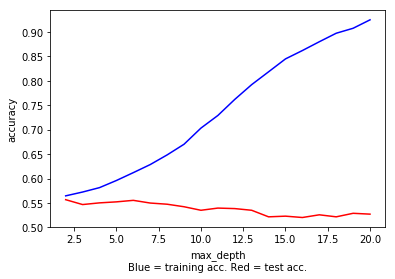

In [15]:
import matplotlib.pyplot as plt

# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(range(2, 21), train_score, 'b', range(2,21), test_score, 'r')
plt.xlabel('max_depth\nBlue = training acc. Red = test acc.')
plt.ylabel('accuracy')
plt.show()

From the resulting plot, we can see the effect of complexity to overfitting. More complex models produce better training accuracy. However, they also result in lower test data accuracy and larger gap between training/test performance, huge indication of overfitting.

Looking at the plot, we could easily point out that a decision tree with `max_depth` of 2 would produce least overfitting. However, in practice, a model complexity is not only determined by one hyperparameters. For a decision tree, it is controlled by `max_depth`, `min_samples_leaf`, `max_features` and many more. Combinations of these hyperparameters produce different models, which makes it difficult to determine the optimal model manually. The next section will guide you to find the optimal hyperparameters in a systematic fashion.

## 4. Finding optimal hyperparameters with GridSearchCV

Let's come back to the question of producing a model that does not overfit. How do we find the optimal combination of hyperparameters for a type of model on a given dataset?

A common method to find this optimal combination is to run an exhaustive search over a subset of possible values of hyperparameters to optimise, commonly known as grid search. Assume we would like to find the optimal `max_depth` and `min_samples_leaf` for our decision tree. We would like to try maximum of [5, 10, 20] depth and [10, 20, 30] minimum samples in a leaf. Grid search creates combinations of these two parameters (3x3 = 9 possible combinations), build models with these parameter combinations, evaluate the performance on **validation** dataset and choose the one that perform the best.

In performing grid search, k-fold cross validation is commonly used. With this approach, each hyperparameter combination is trained and validated in $k$-fold CV fashion, and the average performance values produced are used to determine the best hyperparameter combination.

In `sklearn`, grid search + k-fold validation is implemented in `GridSearchCV`.

In [16]:
from sklearn.model_selection import GridSearchCV

To perform a GridSearchCV, we first have to determine the hyperparameters and possible values to explore. Each class of predictive models have different kind of hyperparameters (e.g. decision tree will be different to a regression). For this practical, we will focus on 3 hyperparameters:

1. Criterion: The function to measure the quality of a split. There are two criterias we will use, “gini” for the Gini impurity and “entropy” for the information gain.
2. Max depth: The maximum depth of the tree. From the plot produced in section 3.3., the model performs very well at lower max_depth. Thus, start with range of 2-7.
3. Min samples leaf: The minimum number of samples required to be at a leaf node, allowing us to limit the minimum size of a leaf node. Use the range of 20-50 with step of 10.

In [17]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7),
          'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

# test the best model
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.5941002949852507
Test accuracy: 0.5750172057811425
              precision    recall  f1-score   support

           0       0.57      0.63      0.60      1453
           1       0.58      0.52      0.55      1453

   micro avg       0.58      0.58      0.58      2906
   macro avg       0.58      0.58      0.57      2906
weighted avg       0.58      0.58      0.57      2906

{'criterion': 'gini', 'min_samples_leaf': 50, 'max_depth': 5}


We can see that the test `accuracy` of our model is hugely improved over the previous best (small decision tree in section 3.2.). The best hyperparameters produced by the GridSearchCV provides us with clues of direction to optimise. Let's do another grid search, now being more specific around the best hyperparameters.

In [18]:
# grid search CV #2
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 6),
          'min_samples_leaf': range(45, 56)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

# test the best model
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.5941002949852507
Test accuracy: 0.5750172057811425
              precision    recall  f1-score   support

           0       0.57      0.63      0.60      1453
           1       0.58      0.52      0.55      1453

   micro avg       0.58      0.58      0.58      2906
   macro avg       0.58      0.58      0.57      2906
weighted avg       0.58      0.58      0.57      2906

{'criterion': 'entropy', 'min_samples_leaf': 52, 'max_depth': 5}


After the second CV is finished, we could see the optimal hyperparameter as follows:
* Criterion: entropy
* Max depth: 5
* Min samples leaf: 52

Save this configuration as our **optimal tree**.

Try to experiment with other kinds of hyperparameters and see whether you could do better than this. You can find the list of hyperparameters available in a decision tree in `sklearn`'s `DecisionTreeClassifier` documentation website.

## Tips

1. Always perform feature importance and visualization to understand your decision tree. The model produced by the optimal set of hyperparameters can be found in `.best_estimator_`.
2. We will use feature importance a lot across this decision tree modelling process. Rather than writing the script multiple times (which is tedious and error-prone), we can just wrap them in functions in `dm_tools.py` and import it from there.

In [19]:
# inside `dm_tools.py' together with data_prep()
import numpy as np
import pydot
from io import StringIO
from sklearn.tree import export_graphviz

def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])

def visualize_decision_tree(dm_model, feature_names, save_name):
    dotfile = StringIO()
    export_graphviz(dm_model, out_file=dotfile, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph[0].write_png(save_name) # saved in the following file


In [20]:
# do the feature importance and visualization analysis on GridSearchCV's best model
from dm_tools import analyse_feature_importance, visualize_decision_tree

analyse_feature_importance(cv.best_estimator_, X.columns, 20)
visualize_decision_tree(cv.best_estimator_, X.columns, "optimal_tree.png")

GiftCnt36 : 0.3145747548923073
DemMedHomeValue : 0.16686477652838466
GiftAvgLast : 0.1363572066419375
GiftTimeLast : 0.07734861577872883
DemPctVeterans : 0.048858719278719986
StatusCatStarAll : 0.04487976794207267
GiftCntAll : 0.043629304229231364
PromCntCardAll : 0.037608916167442205
GiftCntCardAll : 0.034123593488031664
PromCnt36 : 0.01910354419233966
StatusCat96NK_A : 0.016241872882363267
GiftTimeFirst : 0.014949559832823851
PromCntCard12 : 0.013663572834417938
GiftAvgCard36 : 0.012727191422559615
GiftAvgAll : 0.011772716724184033
PromCnt12 : 0.007295887164455312
DemCluster_14 : 0.0
DemCluster_10 : 0.0
DemCluster_11 : 0.0
DemCluster_12 : 0.0


![GridSearchCV decision tree](optimal_tree2.png)

## End notes

This practical introduces the concepts and techniques of data partitioning. Using the training/test data, we built decision trees and evaluate performance. We analysed feature importance and visualised the decision tree structure. Upon discovering overfitting, we optimised the hyperparameters of the decision trees using GridSearchCV and managed to improve its performance on test dataset.